# Applying a FIR filter

How to apply a FIR filter: convolve, fftconvolve, convolve1d or lfilter?
------------------------------------------------------------------------

The following plot shows the time required to apply a finite impulse
response (FIR) filter of varying length to a signal of length 131072
using several different functions that are available in numpy and scipy.
The details of how this figure was created are given below.

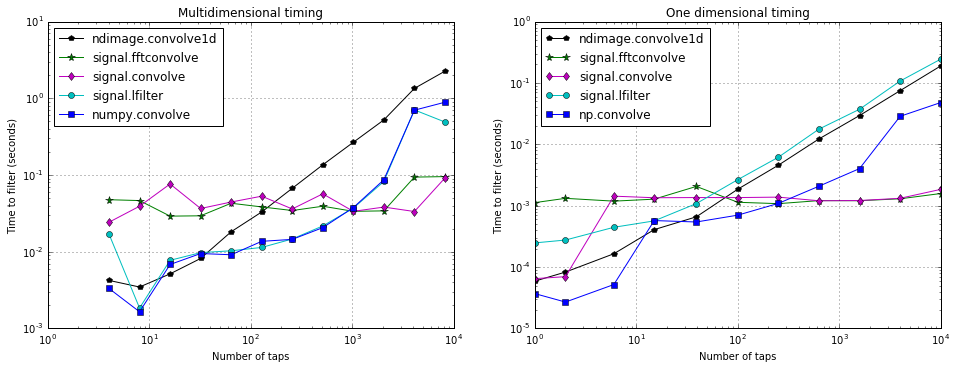

In [49]:
fig

The Details
-----------

There are several functions in the numpy and scipy libraries that can be
used to apply a [FIR
filter](http://en.wikipedia.org/wiki/Finite_impulse_response) to a
signal. From scipy.signal, lfilter() is designed to apply a discrete
[IIR filter](http://en.wikipedia.org/wiki/Infinite_impulse_response) to
a signal, so by simply setting the array of denominator coefficients to
[1.0], it can be used to apply a FIR filter. Applying a FIR filter is
equivalent to a discrete
[convolution](http://en.wikipedia.org/wiki/Convolution), so one can also
use convolve() from numpy, convolve() or fftconvolve() from
scipy.signal, or convolve1d() from scipy.ndimage. In this page, we
demonstrate each of these functions, and we look at how the
computational time varies when the data signal size is fixed and the FIR
filter length is varied. We'll use a data signal length of 131072, which
is 2\*\*17. We assume that we have *m* channels of data, so our input
signal is an *m* by *n* array. For the one dimensional timing, we use use 
a source array the size of 2\*10^4 with varying number of filter coefficients.

We assume our FIR filter coefficients are in a one-dimensional array
*b*. The function numpy.convolve only accepts one-dimensional arrays, so
we'll have to use a python loop over our input array to perform the
convolution over all the channels. One way to do that is

    y = np.array([np.convolve(xi, b, mode='valid') for xi in x])

We use a list comprehension to loop over the rows of *x*, and pass the
result to *np.array* to reassemble the filtered data into a
two-dimensional array. It should be noted that in the one-dimensional case,
`scipy.signal.convolve` possibly uses `np.convolve`.

Both `signal.convolve` and `signal.fftconvolve` perform a two-dimensional
convolution of two-dimensional arrays. To filter our *m* by *n* array
with either of these functions, we shape our filter to be a
two-dimensional array, with shape 1 by *len(b)*. The python code looks
like this:

    y = convolve(x, b[np.newaxis, :], mode='valid')

where *x* is a numpy array with shape *(m, n)*, and *b* is the
one-dimensional array of FIR filter coefficients. *b[np.newaxis, :]* is
the two dimensional view of *b*, with shape 1 by *len(b)*. *y* is the
filtered data; it includes only those terms for which the full
convolution was computed, so it has shape *(m, n - len(b) + 1)*.

ndimage.convolve1d() is designed to do a convolution of a 1d array along
the given axis of another n-dimensional array. It does not have the
option mode='valid', so to extract the valid part of the result, we
slice the result of the function:

    y = convolve1d(x, b)[:, (len(b)-1)//2 : -(len(b)//2)]
    
signal.lfilter is designed to filter one-dimensional data. It can take a
two-dimensional array (or, in general, an n-dimensional array) and
filter the data in any given axis. It can also be used for IIR filters,
so in our case, we'll pass in [1.0] for the denominator coefficients. In
python, this looks like:

    y = lfilter(b, [1.0], x)

To obtain exactly the same array as computed by convolve or fftconvolve
(i.e. to get the equivalent of the 'valid' mode), we must discard the
beginning of the array computed by lfilter. We can do this by slicing
the array immediately after the call to filter:

    y = lfilter(b, [1.0], x)[:, len(b) - 1:]

The following script computes and plots the results of applying a FIR
filter to a 2 by 131072 array of data, with a series of FIR filters of
increasing length.

In [9]:
#!python
%matplotlib inline
from __future__ import print_function
import time

import numpy as np
from numpy import convolve as np_convolve
from scipy.signal import fftconvolve, lfilter, firwin
from scipy.signal import convolve as sig_convolve
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

In [10]:
# Create the m by n data to be filtered.
m = 1
n = 2 ** 18
x = np.random.random(size=(m, n))

conv_time = []
npconv_time = []
fftconv_time = []
conv1d_time = []
lfilt_time = []

diff_list = []
diff2_list = []
diff3_list = []

ntaps_list = 2 ** np.arange(2, 14)

for ntaps in ntaps_list:
    # Create a FIR filter.
    b = firwin(ntaps, [0.05, 0.95], width=0.05, pass_zero=False)

    # --- signal.convolve ---
    tstart = time.time()
    conv_result = sig_convolve(x, b[np.newaxis, :], mode='valid')
    conv_time.append(time.time() - tstart)

    # --- numpy.convolve ---
    tstart = time.time()
    npconv_result = np.array([np_convolve(xi, b, mode='valid') for xi in x])
    npconv_time.append(time.time() - tstart)

    # --- signal.fftconvolve ---
    tstart = time.time()
    fftconv_result = fftconvolve(x, b[np.newaxis, :], mode='valid')
    fftconv_time.append(time.time() - tstart)

    # --- convolve1d ---
    tstart = time.time()
    # convolve1d doesn't have a 'valid' mode, so we expliclity slice out
    # the valid part of the result.
    conv1d_result = convolve1d(x, b)[:, (len(b)-1)//2 : -(len(b)//2)]
    conv1d_time.append(time.time() - tstart)

    # --- lfilter ---
    tstart = time.time()
    lfilt_result = lfilter(b, [1.0], x)[:, len(b) - 1:]
    lfilt_time.append(time.time() - tstart)

    diff = np.abs(fftconv_result - lfilt_result).max()
    diff_list.append(diff)

    diff2 = np.abs(conv1d_result - lfilt_result).max()
    diff2_list.append(diff2)

    diff3 = np.abs(npconv_result - lfilt_result).max()
    diff3_list.append(diff3)

# Verify that np.convolve and lfilter gave the same results.
print("Did np.convolve and lfilter produce the same results?",)
check = all(diff < 1e-13 for diff in diff3_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that fftconvolve and lfilter gave the same results.
print( "Did fftconvolve and lfilter produce the same results?")
check = all(diff < 1e-13 for diff in diff_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

# Verify that convolve1d and lfilter gave the same results.
print( "Did convolve1d and lfilter produce the same results?",)
check = all(diff2 < 1e-13 for diff2 in diff2_list)
if check:
    print( "Yes.")
else:
    print( "No!  Something went wrong.")

Did np.convolve and lfilter produce the same results?
Yes.
Did fftconvolve and lfilter produce the same results?
Yes.
Did convolve1d and lfilter produce the same results?
Yes.


In [52]:
def timeit(fn, shape, lfilter=False, n_x=2e4, repeats=3):
    x = np.random.rand(int(n_x))
    y = np.random.rand(*shape)
    args = [x, y] if not lfilter else [x, x, y]
    times = []
    for _ in range(int(repeats)):
        start = time.time()
        c = fn(*args)
        times += [time.time() - start]
    return min(times)
    
npconv_time2, conv_time2, conv1d_time2 = [], [], []
fftconv_time2, sig_conv_time2, lconv_time2 = [], [], []
Ns_1d = 2*np.logspace(0, 4, num=11, dtype=int)
for n in Ns_1d:
    npconv_time2 += [timeit(np_convolve, shape=(n,))]
    conv1d_time2 += [timeit(convolve1d, shape=(n,))]
    fftconv_time2 += [timeit(fftconvolve, shape=(n,))]
    sig_conv_time2 += [timeit(sig_convolve, shape=(n,))]
    lconv_time2 += [timeit(lfilter, shape=(n,), lfilter=True)]

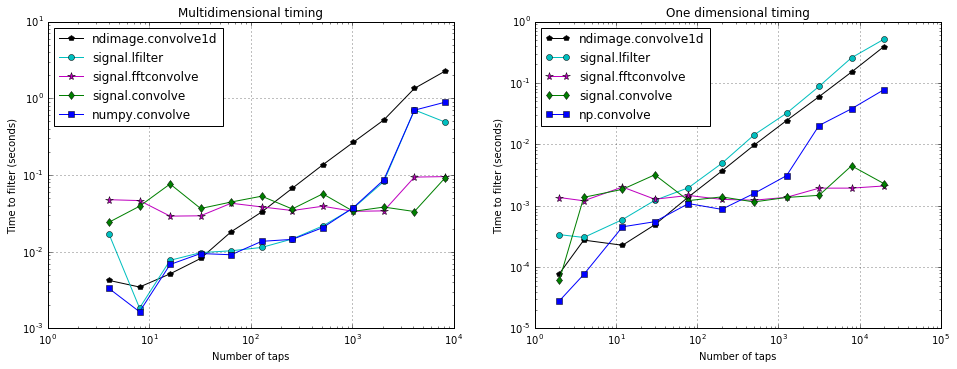

In [53]:
fig = plt.figure(1, figsize=(16, 5.5))
plt.subplot(1, 2, 1)
plt.loglog(ntaps_list, conv1d_time, 'k-p', label='ndimage.convolve1d')
plt.loglog(ntaps_list, lfilt_time, 'c-o', label='signal.lfilter')
plt.loglog(ntaps_list, fftconv_time, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(ntaps_list[:len(conv_time)], conv_time, 'g-d', label='signal.convolve')
plt.loglog(ntaps_list, npconv_time, 'b-s', label='numpy.convolve')
plt.legend(loc='best', numpoints=1)
plt.grid(True)
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('Multidimensional timing')

plt.subplot(1, 2, 2)
plt.loglog(Ns_1d, conv1d_time2, 'k-p', label='ndimage.convolve1d')
plt.loglog(Ns_1d, lconv_time2, 'c-o', label='signal.lfilter')
plt.loglog(Ns_1d, fftconv_time2, 'm-*', markersize=8, label='signal.fftconvolve')
plt.loglog(Ns_1d, sig_conv_time2, 'g-d', label='signal.convolve')
plt.loglog(Ns_1d, npconv_time2, 'b-s', label='np.convolve')
plt.grid()
plt.xlabel('Number of taps')
plt.ylabel('Time to filter (seconds)')
plt.title('One dimensional timing')
plt.legend(loc='best')
plt.show()

The plot shows that, depending on the number of taps, either 
`numpy.convolve` or `scipy.signal.fftconvolve`/`scipy.signal.convolve` is the fastest.
The above script can be used to explore variations of these results.

It should be noted that `scipy.signal.convolve` makes a choice to use
`scipy.signal.fftconvolve`, `np.convolve` or the convolve implementation found
naturally in `scipy.signal.convolve` depending on the size/shape of the input arrays.